# Get data for tests
Get model files for Coral TPU benchmark tests.

* [Selflink](https://colab.research.google.com/drive/1YLFMUxzHETAuOK69X_YQ_ei913W5cTMo)
* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

Useful links:
* [TensorFlow models on the Edge TPU](https://coral.ai/docs/edgetpu/models-intro/#compatibility-overview)
* [Colab tutorials for Coral](https://github.com/google-coral/tutorials)
* [Retrain MobileNet V2 classifier for the Edge TPU (TF2)](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

## Helper functions

In [ ]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
# from IPython.display import display
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


# def show(images, cmap="viridis"):
#     """ Show images with matplotlib. Default color map is "viridis" """
#     for key, value in images.items():
#         value = value.resize((100, 100))
#         display(value)


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz



## Predict ImageNet classes with MobileNet v1, v2 and v3

Take different versions of MobileNet (`alpha=1.0`) and EfficientNet for [ImageNet](https://www.image-net.org/) dataset with `input_shape=(224,224)`:
   * [MobileNetV1](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet)
   * [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)
   * [MobileNetV3Large](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large)
   * [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small)
   * [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0)
   * [EfficientNetV2B0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0)


human.jpg
panda.jpg
parrot.jpg
cat.jpg


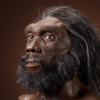

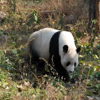

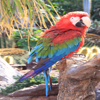

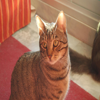

In [ ]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
# from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.models import save_model, load_model


# Create "temp" directory and make it the current dir
temp_dir = "temp"
this_dir = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(this_dir) == temp_dir:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(temp_dir):  # directory does not exist
        os.makedirs(temp_dir)
    os.chdir(os.path.join(this_dir, temp_dir))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg",
        "cat.jpg":    "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/cat.jpg",
        "panda.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/panda.jpg",
        "human.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/human.jpg",
}
img_paths = []
for name, url in urls.items():
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 22  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]


# MobileNet models dictionary in the format:
#     key: [name, model, api, results]
net = {
    "MobileNetV1": ["mobilenetv1_1.0_224",  # v[0] filename
                    apps.MobileNet(),       # v[1] model architecture
                    apps.mobilenet,         # v[2] API
                    "model placeholder",    # v[3] model placeholder
                    True,                   # v[4] normalize
                    IMAGE_SHAPE],           # v[5] im_shape
    "MobileNetV2": ["mobilenetv2_1.0_224",
                    apps.MobileNetV2(),
                    apps.mobilenet_v2,
                    "model placeholder",
                    True,
                    IMAGE_SHAPE],
    "MobileNetV3Large": ["mobilenetv3large_1.0_224",
                         apps.MobileNetV3Large(input_shape=IMAGE_SHAPE),
                         apps.mobilenet_v3,
                         "model placeholder",
                         False,
                         IMAGE_SHAPE],
    "MobileNetV3Small": ["mobilenetv3small_1.0_224",
                         apps.MobileNetV3Small(input_shape=IMAGE_SHAPE),
                         apps.mobilenet_v3,
                         "model placeholder",
                         False,
                         IMAGE_SHAPE],
    "EfficientNetB0": ["efficientnetb0_224",
                       apps.EfficientNetB0(),
                       apps.efficientnet,
                       "model placeholder",
                       False,
                       IMAGE_SHAPE],
    "EfficientNetV2B0": ["efficientnetv2b0_224",
                         apps.EfficientNetB0(),
                         apps.efficientnet_v2,
                         "model placeholder",
                         False,
                         IMAGE_SHAPE],
    "EfficientNetV2S": ["efficientnetv2s_224",
                        apps.EfficientNetB0(),
                        apps.efficientnet_v2,
                        "model placeholder",
                        False,
                        IMAGE_SHAPE],
    "ConvNeXtTiny": ["convnexttiny_224",
                     apps.ConvNeXtTiny(),
                     apps.convnext,
                     "model placeholder",
                     False,
                     IMAGE_SHAPE],
    "ConvNeXtBase": ["convnextbase_224",
                     apps.ConvNeXtBase(),
                     apps.convnext,
                     "model placeholder",
                     False,
                     IMAGE_SHAPE],
    "DenseNet121": ["densenet121_224",
                    apps.DenseNet121(),
                    apps.densenet,
                    "model placeholder",
                    True,
                    IMAGE_SHAPE],
    "InceptionV3": ["inceptionv3_299",
                    apps.InceptionV3(input_shape=IMAGE_SHAPE2),
                    apps.inception_v3,
                    "model placeholder",
                    True,
                    IMAGE_SHAPE2],
    "ResNet50": ["resnet50_224",
                 apps.ResNet50(),
                 apps.resnet,
                 "model placeholder",
                 True,
                 IMAGE_SHAPE],
    "ResNet101": ["resnet101_224",
                  apps.ResNet101(),
                  apps.resnet,
                  "model placeholder",
                  True,
                  IMAGE_SHAPE],
    "ResNet50V2": ["resnet50v2_224",
                   apps.ResNet50V2(),
                   apps.resnet_v2,
                   "model placeholder",
                   True,
                   IMAGE_SHAPE],
    "ResNet101V2": ["resnet101v2_224",
                    apps.ResNet101V2(),
                    apps.resnet_v2,
                    "model placeholder",
                    True,
                    IMAGE_SHAPE],
    "VGG16": ["vgg16_224",
              apps.VGG16(),
              apps.vgg16,
              "model placeholder",
              True,
              IMAGE_SHAPE],
    "Xception": ["xception_299",
                 apps.Xception(),
                 apps.xception,
                 "model placeholder",
                 True,
                 IMAGE_SHAPE2],
}

## Check models

In [ ]:
def prepare_image(img_path, preprocess_input, im_shape):
    """ Prepare image for the model """
    # interpolation="lanczos" is better than default "nearest"
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)
    img = preprocess_input(img)
    # plt.imshow(img); plt.show()  # show image if necessary
    img = np.expand_dims(img, axis=0)
    return img


def predict(img, model, decode_predictions):
    """ Predict and decode results """
    # Use "model(img)" instead of "model.predict(img)", because
    # this code gets a retracing warning:
    #     "WARNING : tensorflow:5 out of the last 5 calls to..."
    preds = model(img, training=False).numpy()
    results = decode_predictions(preds, top=3)[0]
    # Return list of tuples (description, probability)
    return [(i[1], f"{i[2]:.4f}") for i in results]


# Predict images
for img_path in img_paths:
    # Prepare image and predict
    for k, v in net.items():
        img = prepare_image(img_path, v[2].preprocess_input, v[5])
        v[3] = predict(img, v[1], v[2].decode_predictions)

    # Show predicitons
    print(f"\n" f"Predictions for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:12} {v[3]}")


Predictions for 'parrot.jpg' image are:
MobileNetV1  [('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0001')]
MobileNetV2  [('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
MobileNetV3Large [('macaw', '0.9773'), ('bee_eater', '0.0018'), ('lorikeet', '0.0011')]
MobileNetV3Small [('macaw', '0.7953'), ('bee_eater', '0.1064'), ('lorikeet', '0.0069')]
EfficientNetB0 [('macaw', '0.9392'), ('bee_eater', '0.0058'), ('lorikeet', '0.0032')]
EfficientNetV2B0 [('macaw', '0.9392'), ('bee_eater', '0.0058'), ('lorikeet', '0.0032')]
EfficientNetV2S [('macaw', '0.9392'), ('bee_eater', '0.0058'), ('lorikeet', '0.0032')]
ConvNeXtTiny [('macaw', '0.8724'), ('lorikeet', '0.0006'), ('bee_eater', '0.0005')]
ConvNeXtBase [('macaw', '0.9468'), ('lorikeet', '0.0005'), ('African_grey', '0.0004')]
DenseNet121  [('macaw', '0.9969'), ('bee_eater', '0.0023'), ('lorikeet', '0.0004')]
InceptionV3  [('macaw', '0.9716'), ('lorikeet', '0.0015'), ('bee_eater', '0.0005')]
ResNet50     [(

## Save and load models

In [ ]:
def save(model, name):
    """ Save model in *.tgz (tar.gz) archive file """
    # Set optimizer, loss and metrics for evaluation and warning supress
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    save_model(model, name)  # save model in a directory
    # tf.saved_model.save(model, path)  # some other API
    tgz(name)  # archive directory in *.tgz file, the same as *.tar.gz


def load(model_path, unpack=True):
    """ Load model from file """
    if unpack:
        extract(model_path + ".tgz")  # extract from "*.tgz" archive
    model = load_model(model_path)  # load model
    return model


for k, v in net.items():
    print(separator(v[0]))
    # save(v[1], v[0])  # save model in *.tgz archive
    v[1].save(f"{v[0]}.h5")  # save model in .h5 format

------------------------ mobilenetv1_1.0_224  ------------------------
------------------------ mobilenetv2_1.0_224  ------------------------
---------------------- mobilenetv3large_1.0_224 ----------------------
---------------------- mobilenetv3small_1.0_224 ----------------------
------------------------- efficientnetb0_224 -------------------------
------------------------ efficientnetv2b0_224 ------------------------
------------------------ efficientnetv2s_224  ------------------------
-------------------------- convnexttiny_224 --------------------------
-------------------------- convnextbase_224 --------------------------
-------------------------- densenet121_224  --------------------------
-------------------------- inceptionv3_299  --------------------------
---------------------------- resnet50_224 ----------------------------
--------------------------- resnet101_224  ---------------------------
--------------------------- resnet50v2_224 ---------------------------
------

## Download data for representative dataset
Download Git [imagenet-sample-images](https://github.com/EliSchwartz/imagenet-sample-images): 1000 images, one random image per ImageNet class. To make full integer quantization.

In [ ]:
# Download imagenet-sample-images dataset
dir_name = "imagenet-sample-images"
if os.path.exists(dir_name) and os.path.isdir(dir_name):
    pass  # already exsists
else:
    !git clone https://github.com/EliSchwartz/imagenet-sample-images

DS_IMAGES = get_images("imagenet-sample-images")
print(f"Number of images: {len(DS_IMAGES)}")

Number of images: 1000


## Convert to TF Lite

In [ ]:
def representative_dataset(model_path, normalize, im_shape):
    """ Integer quantization requires a representative dataset, i.e. a few
        images from the training dataset, for the conversion to happen.
        This dataset can be a small subset (around ~100-500 samples)
        of the training or validation data. """
    images = []

    # # Use ImageNet-v2 dataset
    # for data in DS.take(150):  # take ~100-500 samples
    #     img = tf.image.resize(data["image"], im_shape[0:2], method=RESIZE_METHOD2)

    # Use imagenet-sample-images
    for name, img in list(DS_IMAGES.items())[:150]:  # take ~100-500 samples
        img = tf.image.resize(img, im_shape[0:2], method=RESIZE_METHOD2)

        img = tf.cast(img, tf.float32)  # convert from uint8 to float32
        if normalize:  # normalize image
            img = img / 127.5 - 1.0
        else:  # don't normalize
            pass
        images.append(img)

    # Return (yield) slices (1,224,224,3) from "images" list
    slices = tf.data.Dataset.from_tensor_slices(images).batch(1)
    for s in slices:
        yield [s]


def tflite_convert(name, norm, im_shape, ext=".tflite", unpack=False, optim=None):
    """ Convert the model to TF Lite """
    # Untar *.tgz file with the model (not necessary in this notebook)
    if unpack:
        extract(name + ".tgz")
    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(name)

    if optim is None:  # no quantization
        print(separator(f"TF Lite convertion for {name}"))
    # Q1. Dynamic range quantization
    if optim == "dynamic":
        print(separator(f"Dynamic range quantization for {name}"))
        ext = "_dynamic" + ext
        converter.optimizations = [
            tf.lite.Optimize.DEFAULT,  # set the optimization mode
            # size reduction optimization doesn't work for standard model
            tf.lite.Optimize.EXPERIMENTAL_SPARSITY,  # size reduction
        ]
    # Q2. Float16 quantization
    elif optim == "float16":
        print(separator(f"Float16 quantization for {name}"))
        ext = "_float16" + ext
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        converter.target_spec.supported_types = [tf.float16]  # float16 quantization
    # Q3. Full integer quantization
    elif optim == "int8":
        print(separator(f"Full integer quantization for {name}"))
        ext = "_int8" + ext
        # This enables quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        # This sets the representative dataset for quantization
        converter.representative_dataset = lambda: representative_dataset(name, norm, im_shape)
        # This ensures that if any ops can't be quantized, the converter throws an error
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        # These set the input and output tensors to uint8
        converter.inference_input_type = tf.uint8  # or tf.int8
        converter.inference_output_type = tf.uint8  # or tf.int8
    elif optim is not None:
        print(f"Warning: no such optimization `{optim}`.")

    model_tflite = converter.convert()
    del converter
    # Save the TFLite model
    tf.io.write_file(name + ext, model_tflite)

In [ ]:
length = len(net)
for i, (k, v) in enumerate(net.items(), 1):
    #if i > 0:  # convert all
    #if i > length-2:  # convert 2 last models only
        tflite_convert(v[0], v[4], v[5], unpack=True)
        tflite_convert(v[0], v[4], v[5], unpack=True, optim="int8")

------------------ TF Lite convertion for vgg16_224 ------------------
-------------- Full integer quantization for vgg16_224  --------------
---------------- TF Lite convertion for xception_299  ----------------
------------- Full integer quantization for xception_299 -------------


## Compile for the Edge TPU
Finally, we're ready to compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt update

!sudo apt install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  18354      0 --:--:-- --:--:-- --:--:-- 18465
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [805 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [1,423 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4

Then compile the model.

The compiled model uses the same filename but with "_edgetpu" appended at the end.

In [ ]:
for k, v in net.items():
    print(separator(f"{v[0]}"))
    !edgetpu_compiler {v[0]}_int8.tflite

------------------------ mobilenetv1_1.0_224  ------------------------
Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
ERROR: Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors.
Compilation failed: Model failed in Tflite interpreter. Please ensure model can be loaded/run in Tflite interpreter.
Compilation child process completed within timeout period.
Compilation failed! 
------------------------ mobilenetv2_1.0_224  ------------------------
Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1808 ms.

Input model: mobilenetv2_1.0_224_int8.tflite
Input size: 3.81MiB
Output model: mobilenetv2_1.0_224_int8_edgetpu.tflite
Output size: 4.06MiB
On-chip memory used for caching model parameters: 3.88MiB
On-chip memory remaining for caching model parameters: 3.81MiB
Off-chip memory used for streaming uncached model p

## Save to Google Drive (up to 15 GB)

In [ ]:
# %%script echo "Skip this cell"

dir_name = ".."
dir_src = "/content/drive"

!pwd  # show current directory

# Archive 'temp' directory
!zip -r $dir_name/all_files.zip $dir_name/temp/ -i "*.tflite" "*.tgz" "*.log"  #>/dev/null 2>&1

if os.path.exists(dir_src) and os.path.isdir(dir_src):
    pass
else:
    # Connect to your Google Drive (max 15 GB free storage)
    from google.colab import drive
    drive.mount(dir_src)

# Copy archive to Google Drive. Can download it later in background mode
!cp $dir_name/all_files.zip $dir_src/MyDrive

print("Finished")

/content/temp
Mounted at /content/drive
Finished
